Let's query some interesting stuff about foods

In [98]:
import pandas as pd # for loading data
import mysql.connector as con
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
connection = con.connect(user = 'root', password = 'root', database = 'foodb')

Let's query some interesting data about foods

In [73]:
foods = pd.read_sql("SELECT f.id, f.name, f.food_subgroup, COUNT(DISTINCT c.source_id) AS nnutrients FROM foods AS f, contents AS c " + 
                    "WHERE f.id = c.food_id AND c.source_type = \"Nutrient\" GROUP BY f.id", connection)

In [41]:
foods.head()

,id,name,food_subgroup,nnutrients
0,2,Savoy cabbage,Cabbages,7
1,4,Kiwi,Tropical fruits,17
2,5,Allium (Onion),Onion-family vegetables,33
3,6,Garden onion,Onion-family vegetables,3
4,7,Leek,Onion-family vegetables,7


I will query the top 20 compounds that are present in most of the foods and add them to the foods table

In [11]:
compounds = pd.read_sql("SELECT ta.source_id, comp.name, ta.cnt FROM (SELECT source_id, COUNT(*) AS cnt " + 
                    "FROM `contents` WHERE source_type = \"Compound\" GROUP BY source_id ORDER BY cnt DESC LIMIT 20) ta, compounds " + 
                    "AS comp WHERE ta.source_id = comp.id" , connection)

In [12]:
compounds.head()

,source_id,name,cnt
0,14507,Folic acid,28009
1,13831,Retinol,22931
2,21595,Unsaturated fatty acids,18776
3,13267,Cyanocobalamin,12424
4,565,alpha-Tocopherol,11536


Let's rename some of the entries, so we can recognize them more easily

In [36]:
compounds.name = compounds.name.replace(
    ["Retinol", 
     "Cyanocobalamin", 
     "alpha-Tocopherol", 
     "L-Ascorbic acid", 
     "Riboflavine"], 
    ["VitaminA1", "VitaminB12", 
     "VitaminE", "VitaminC", "VitaminB2"]).str.replace(' ', '')

In [37]:
compounds.head()

,source_id,name,cnt
0,14507,Folicacid,28009
1,13831,VitaminA1,22931
2,21595,Unsaturatedfattyacids,18776
3,13267,VitaminB12,12424
4,565,VitaminE,11536


In [75]:
for _, row in compounds.iterrows():
    
    df = pd.read_sql("SELECT food_id, standard_content FROM `contents` " + 
                     "WHERE source_type = \"Compound\" AND source_id = " + str(row['source_id'])
                     , connection)
    grouped = df.groupby('food_id')
    df = grouped.median().reset_index()
    df.columns = ['food_id', row['name']]
    foods = foods.merge(df, 'left', left_on = 'id', right_on = 'food_id')
    del foods['food_id'] # remove extra column

foods = foods.dropna()

In [106]:
foods.head()

,id,name,food_subgroup,nnutrients,Folicacid_x,VitaminA1_x,Folicacid_y,VitaminA1_y,Unsaturatedfattyacids,VitaminB12,...,Calcium,Ash,Iron,Sodium,Potassium,Phosphorus,Cholesterol,Magnesium,VitaminB2,Zinc
0,2,Savoy cabbage,Cabbages,7,0.0800,0.0,0.080,25.0,3.5,0.0,...,35.0,800.0,0.40,28.0,230.0,42.0,0.0,28.0,0.0300,0.27
1,4,Kiwi,Tropical fruits,17,0.0295,0.0,0.034,4.0,73.5,0.0,...,32.9,730.0,0.30,3.0,314.0,33.4,0.0,15.5,0.0355,0.10
2,5,Allium (Onion),Onion-family vegetables,33,0.0150,0.0,0.020,0.0,36.5,0.0,...,27.0,800.0,0.34,16.0,146.0,33.0,0.0,10.0,0.0270,0.21
4,7,Leek,Onion-family vegetables,7,0.0820,0.0,0.082,8.9,107.0,0.0,...,42.3,800.0,0.90,9.0,236.0,45.6,0.0,10.0,0.1000,0.29
5,8,Garlic,Herbs,24,0.0030,0.0,0.025,0.0,146.5,0.0,...,49.8,2400.0,1.70,17.0,401.0,160.0,0.0,25.0,0.1255,1.16


In [117]:
from sklearn.decomposition import PCA
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed


'Tropical fruits'

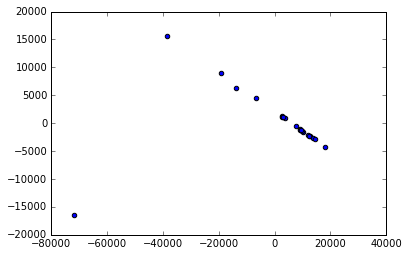

In [134]:
pca = PCA(n_components = 2)

def select(subgroup):
    df = foods[foods.food_subgroup == subgroup].drop(['name', 'food_subgroup', 'id'], 1)
    pca.fit(df)
    out = pca.transform(df)
    plt.scatter(x = out[:, 0], y = out[:, 1])
    return subgroup
interact(select, subgroup=['Cabbages','Tropical fruits'])